# Machine Learning Essentials SS25 - Exercise Sheet 5

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

## Exercise 1

## Exercise 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# TODO: Import the stuff you need from torch and torchvision
import torch
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split, DataLoader
from torch import nn, optim

""""
If you stay in ML-related fields, you will likely be working on a server or cluster. If you do so,
always remember to set the number of CPU (or even GPU) threads you're using, as Jupyter notebooks or Python scripts 
might sometimes use all available threads by default, which will lead to unhappy colleagues or classmates that
also want to use some of the threads.
"""
# Example of limiting CPU threads:
# import os
# os.environ["OMP_NUM_THREADS"] = "15"
# os.environ["MKL_NUM_THREADS"] = "15"
# torch.set_num_threads(15) # If you only want to use PyTorch threads

'"\nIf you stay in ML-related fields, you will likely be working on a server or cluster. If you do so,\nalways remember to set the number of CPU (or even GPU) threads you\'re using, as Jupyter notebooks or Python scripts \nmight sometimes use all available threads by default, which will lead to unhappy colleagues or classmates that\nalso want to use some of the threads.\n'

In [2]:
num_workers = 8

### 2.1

In [3]:
# TODO: Define transformations
# Given statistics of training set:
mu_train = 0.286
std_train = 0.353
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mu_train,), (std_train,))
])

# TODO: Load FashionMNIST train/testsets
train_dataset_full = FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"Full training dataset size: {len(train_dataset_full)}")
print(f"Test dataset size: {len(test_dataset)}")

Full training dataset size: 60000
Test dataset size: 10000


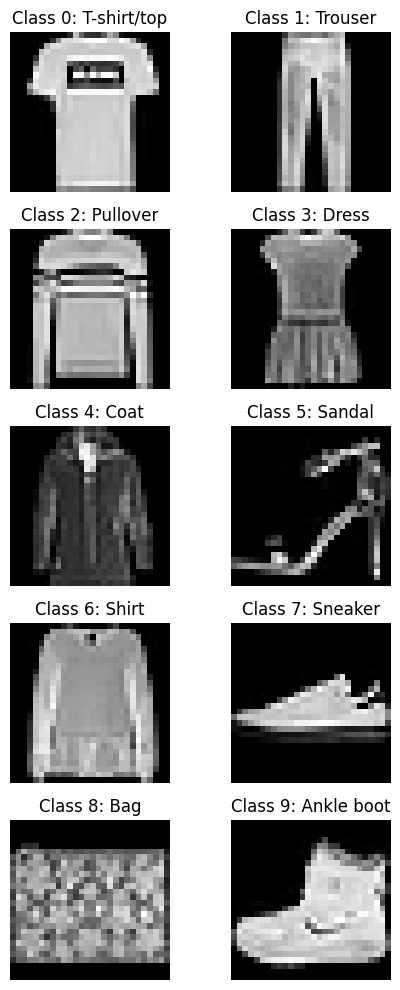

In [4]:
# TODO: Create 5x2 subplot grid w/ example image for each class
fig, axes = plt.subplots(5, 2, figsize=(5, 10))
for i in range(10):
    img = np.where(train_dataset_full.targets == i)[0][0]
    img_tensor = train_dataset_full[img][0]
    img_array = img_tensor.numpy().squeeze()  
    ax = axes[i // 2, i % 2]
    ax.imshow(img_array, cmap='gray')
    ax.set_title(f'Class {i}: {train_dataset_full.classes[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# TODO: Create a validation set from the training set
validation_size = 10000
train_size = len(train_dataset_full) - validation_size
train_dataset, validation_dataset = random_split(
    train_dataset_full, [train_size, validation_size]
)

### 2.2

In [6]:
# TODO: Define your model architecture: A class called MLP that inherits from nn.Module
class MLP(nn.Module):
    def __init__(self, input_size=28*28, k=10, hidden_size=128, output_size=10):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        for _ in range(k):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return nn.functional.softmax(self.model(x), dim=1)
            

# TODO: Define appropriate loss
criterion = nn.CrossEntropyLoss()

### 2.3

In [7]:
BATCH_SIZE_DEFAULT = 2048 # TODO: Set your default batch size. The capitalization is a convention used for global constants in Python

#TODO: Define DataLoaders for training, validation, and test sets
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE_DEFAULT,
    shuffle=True,
    num_workers=num_workers
)
validation_loader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE_DEFAULT,
    shuffle=False,
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_DEFAULT,
    shuffle=False,
    num_workers=num_workers
)

In [14]:
def calculate_accuracy(outputs, labels):
    """
    Calculate accuracy given model outputs and true labels.
    """
    _, predicted = torch.max(outputs.data, 1) # Prediction = class with highest output probability
    total = labels.size(0) 
    correct = (predicted == labels).sum().item() #.item() converts a single-element tensor to a Python number ("scalar")
    return correct / total

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Device configuration: if available use GPU (needs CUDA installed and GPU with PyTorch support), otherwise CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Training on device: {device}")

    # TODO: Define training loop that for each epoch iterates over all mini-batches in the training set 
    # Record and return the training&validation loss and accuracy for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        
        # mini batches 
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0

        for _ , (images, labels) in enumerate(train_loader):

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            running_accuracy += calculate_accuracy(outputs, labels)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        train_accuracy = running_accuracy / len(train_loader)
        train_accuracies.append(train_accuracy)

        model.eval()
        
        with torch.no_grad():
            running_val_acc = 0.0
            running_val_loss = 0.0
            for _, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                running_val_acc += calculate_accuracy(outputs, labels)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                
            val_accuracy = running_val_acc / len(val_loader)
            val_accuracies.append(val_accuracy)
            val_loss = running_val_loss / len(val_loader)
            val_losses.append(val_loss)
            
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

### 2.4

In [16]:
# TODO: Define hyperparameter grid for tuning
k = [2, 5, 10]
hidden_size = [32, 64, 128, 256]
batch_size = [256, 512, 1024, BATCH_SIZE_DEFAULT]

# fixed hybperparameters
num_epochs = 100
input_size = 28 * 28  
output_size = 10  

default_k = 2
default_hidden_size = 64


# TODO: For each hyperparameter setting, instantiate model&optimizer, 
# train the model, and store the results for evaluation later
results_k_adam = {}
results_k_sgd = {}
for k_value in k:
    model_adam = MLP(input_size=input_size, k=k_value, hidden_size=default_hidden_size, output_size=output_size)
    model_sgd = MLP(input_size=input_size, k=k_value, hidden_size=default_hidden_size, output_size=output_size)
    optimizer_adam = optim.Adam(model_adam.parameters())
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)

    print(f"Training model with k={k_value} using Adam optimizer")
    train_losses_adam, val_losses_adam, train_accuracies_adam, val_accuracies_adam = train_model(
        model_adam, criterion, optimizer_adam, train_loader, validation_loader, num_epochs
    )
    results_k_adam[k_value] = {
        'train_losses': train_losses_adam,
        'val_losses': val_losses_adam,
        'train_accuracies': train_accuracies_adam,
        'val_accuracies': val_accuracies_adam
    }
    print(f"Training model with k={k_value} using SGD optimizer")
    train_losses_sgd, val_losses_sgd, train_accuracies_sgd, val_accuracies_sgd = train_model(
        model_sgd, criterion, optimizer_sgd, train_loader, validation_loader, num_epochs
    )
    results_k_sgd[k_value] = {
        'train_losses': train_losses_sgd,
        'val_losses': val_losses_sgd,
        'train_accuracies': train_accuracies_sgd,
        'val_accuracies': val_accuracies_sgd
    }

Training model with k=2 using Adam optimizer
Training on device: cuda
Epoch [1/100], Train Loss: 2.1482, Train Accuracy: 0.3721, Val Accuracy: 0.5341
Epoch [2/100], Train Loss: 1.8359, Train Accuracy: 0.6424, Val Accuracy: 0.7378
Epoch [3/100], Train Loss: 1.7132, Train Accuracy: 0.7614, Val Accuracy: 0.7809
Epoch [4/100], Train Loss: 1.6705, Train Accuracy: 0.8005, Val Accuracy: 0.8089
Epoch [5/100], Train Loss: 1.6499, Train Accuracy: 0.8184, Val Accuracy: 0.8185
Epoch [6/100], Train Loss: 1.6379, Train Accuracy: 0.8290, Val Accuracy: 0.8223
Epoch [7/100], Train Loss: 1.6327, Train Accuracy: 0.8334, Val Accuracy: 0.8325
Epoch [8/100], Train Loss: 1.6245, Train Accuracy: 0.8414, Val Accuracy: 0.8369
Epoch [9/100], Train Loss: 1.6199, Train Accuracy: 0.8452, Val Accuracy: 0.8383
Epoch [10/100], Train Loss: 1.6143, Train Accuracy: 0.8508, Val Accuracy: 0.8449
Epoch [11/100], Train Loss: 1.6096, Train Accuracy: 0.8557, Val Accuracy: 0.8485
Epoch [12/100], Train Loss: 1.6064, Train Accura

In [17]:
results_hidden_size_adam = {}
results_hidden_size_sgd = {}

for hidden_size_value in hidden_size:
    model_adam = MLP(input_size=input_size, k=default_k, hidden_size=hidden_size_value, output_size=output_size)
    model_sgd = MLP(input_size=input_size, k=default_k, hidden_size=hidden_size_value, output_size=output_size)
    optimizer_adam = optim.Adam(model_adam.parameters())
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)

    print(f"Training model with hidden size={hidden_size_value} using Adam optimizer")
    train_losses_adam, val_losses_adam, train_accuracies_adam, val_accuracies_adam = train_model(
        model_adam, criterion, optimizer_adam, train_loader, validation_loader, num_epochs
    )
    results_hidden_size_adam[hidden_size_value] = {
        'train_losses': train_losses_adam,
        'val_losses': val_losses_adam,
        'train_accuracies': train_accuracies_adam,
        'val_accuracies': val_accuracies_adam
    }
    
    print(f"Training model with hidden size={hidden_size_value} using SGD optimizer")
    train_losses_sgd, val_losses_sgd, train_accuracies_sgd, val_accuracies_sgd = train_model(
        model_sgd, criterion, optimizer_sgd, train_loader, validation_loader, num_epochs
    )
    results_hidden_size_sgd[hidden_size_value] = {
        'train_losses': train_losses_sgd,
        'val_losses': val_losses_sgd,
        'train_accuracies': train_accuracies_sgd,
        'val_accuracies': val_accuracies_sgd
    }

Training model with hidden size=32 using Adam optimizer
Training on device: cuda
Epoch [1/100], Train Loss: 2.2087, Train Accuracy: 0.3478, Val Accuracy: 0.4094
Epoch [2/100], Train Loss: 1.9125, Train Accuracy: 0.5920, Val Accuracy: 0.6527
Epoch [3/100], Train Loss: 1.7936, Train Accuracy: 0.6811, Val Accuracy: 0.7301
Epoch [4/100], Train Loss: 1.7205, Train Accuracy: 0.7602, Val Accuracy: 0.7651
Epoch [5/100], Train Loss: 1.6946, Train Accuracy: 0.7769, Val Accuracy: 0.7760
Epoch [6/100], Train Loss: 1.6828, Train Accuracy: 0.7860, Val Accuracy: 0.7839
Epoch [7/100], Train Loss: 1.6749, Train Accuracy: 0.7929, Val Accuracy: 0.7887
Epoch [8/100], Train Loss: 1.6701, Train Accuracy: 0.7969, Val Accuracy: 0.7913
Epoch [9/100], Train Loss: 1.6660, Train Accuracy: 0.8004, Val Accuracy: 0.7926
Epoch [10/100], Train Loss: 1.6606, Train Accuracy: 0.8055, Val Accuracy: 0.8014
Epoch [11/100], Train Loss: 1.6582, Train Accuracy: 0.8068, Val Accuracy: 0.8033
Epoch [12/100], Train Loss: 1.6542, T

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [17/100], Train Loss: 1.7508, Train Accuracy: 0.7428, Val Accuracy: 0.7410
Epoch [18/100], Train Loss: 1.7349, Train Accuracy: 0.7507, Val Accuracy: 0.7468
Epoch [19/100], Train Loss: 1.7239, Train Accuracy: 0.7564, Val Accuracy: 0.7539
Epoch [20/100], Train Loss: 1.7174, Train Accuracy: 0.7597, Val Accuracy: 0.7584
Epoch [21/100], Train Loss: 1.7127, Train Accuracy: 0.7623, Val Accuracy: 0.7622
Epoch [22/100], Train Loss: 1.7073, Train Accuracy: 0.7659, Val Accuracy: 0.7631
Epoch [23/100], Train Loss: 1.7034, Train Accuracy: 0.7684, Val Accuracy: 0.7664
Epoch [24/100], Train Loss: 1.6997, Train Accuracy: 0.7715, Val Accuracy: 0.7678
Epoch [25/100], Train Loss: 1.6963, Train Accuracy: 0.7747, Val Accuracy: 0.7701
Epoch [26/100], Train Loss: 1.6938, Train Accuracy: 0.7765, Val Accuracy: 0.7735
Epoch [27/100], Train Loss: 1.6917, Train Accuracy: 0.7782, Val Accuracy: 0.7728
Epoch [28/100], Train Loss: 1.6890, Train Accuracy: 0.7805, Val Accuracy: 0.7769


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [29/100], Train Loss: 1.6870, Train Accuracy: 0.7829, Val Accuracy: 0.7780


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^Exception ignored in: ^    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^self._shutdown_workers()^

^Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^  File "/h

Epoch [30/100], Train Loss: 1.6850, Train Accuracy: 0.7844, Val Accuracy: 0.7795
Epoch [31/100], Train Loss: 1.6833, Train Accuracy: 0.7859, Val Accuracy: 0.7811
Epoch [32/100], Train Loss: 1.6812, Train Accuracy: 0.7874, Val Accuracy: 0.7835
Epoch [33/100], Train Loss: 1.6795, Train Accuracy: 0.7892, Val Accuracy: 0.7837
Epoch [34/100], Train Loss: 1.6778, Train Accuracy: 0.7913, Val Accuracy: 0.7854
Epoch [35/100], Train Loss: 1.6760, Train Accuracy: 0.7932, Val Accuracy: 0.7854
Epoch [36/100], Train Loss: 1.6758, Train Accuracy: 0.7933, Val Accuracy: 0.7871
Epoch [37/100], Train Loss: 1.6736, Train Accuracy: 0.7950, Val Accuracy: 0.7882
Epoch [38/100], Train Loss: 1.6724, Train Accuracy: 0.7959, Val Accuracy: 0.7894
Epoch [39/100], Train Loss: 1.6713, Train Accuracy: 0.7973, Val Accuracy: 0.7907
Epoch [40/100], Train Loss: 1.6699, Train Accuracy: 0.7980, Val Accuracy: 0.7886
Epoch [41/100], Train Loss: 1.6690, Train Accuracy: 0.7990, Val Accuracy: 0.7922


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [42/100], Train Loss: 1.6677, Train Accuracy: 0.7999, Val Accuracy: 0.7921


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^

Traceback (most recent call last):
^Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^        ^self._shutdown_workers()self._shutdown_w

Epoch [43/100], Train Loss: 1.6675, Train Accuracy: 0.8001, Val Accuracy: 0.7919
Epoch [44/100], Train Loss: 1.6665, Train Accuracy: 0.8011, Val Accuracy: 0.7929
Epoch [45/100], Train Loss: 1.6651, Train Accuracy: 0.8024, Val Accuracy: 0.7944
Epoch [46/100], Train Loss: 1.6646, Train Accuracy: 0.8021, Val Accuracy: 0.7940
Epoch [47/100], Train Loss: 1.6641, Train Accuracy: 0.8026, Val Accuracy: 0.7956
Epoch [48/100], Train Loss: 1.6633, Train Accuracy: 0.8038, Val Accuracy: 0.7953
Epoch [49/100], Train Loss: 1.6620, Train Accuracy: 0.8052, Val Accuracy: 0.7960
Epoch [50/100], Train Loss: 1.6614, Train Accuracy: 0.8051, Val Accuracy: 0.7954
Epoch [51/100], Train Loss: 1.6614, Train Accuracy: 0.8054, Val Accuracy: 0.7970
Epoch [52/100], Train Loss: 1.6608, Train Accuracy: 0.8057, Val Accuracy: 0.7973
Epoch [53/100], Train Loss: 1.6589, Train Accuracy: 0.8076, Val Accuracy: 0.7985
Epoch [54/100], Train Loss: 1.6586, Train Accuracy: 0.8080, Val Accuracy: 0.7985
Epoch [55/100], Train Loss: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [59/100], Train Loss: 1.6556, Train Accuracy: 0.8111, Val Accuracy: 0.8017


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
       Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  
^ Traceback (most recent ca

Epoch [60/100], Train Loss: 1.6554, Train Accuracy: 0.8112, Val Accuracy: 0.8019


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
   Exception ignored in: Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> Traceback (most recent call last):

 Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/da

Epoch [61/100], Train Loss: 1.6542, Train Accuracy: 0.8123, Val Accuracy: 0.8010
Epoch [62/100], Train Loss: 1.6542, Train Accuracy: 0.8126, Val Accuracy: 0.8017
Epoch [63/100], Train Loss: 1.6541, Train Accuracy: 0.8130, Val Accuracy: 0.8043
Epoch [64/100], Train Loss: 1.6535, Train Accuracy: 0.8129, Val Accuracy: 0.8018
Epoch [65/100], Train Loss: 1.6526, Train Accuracy: 0.8138, Val Accuracy: 0.8024
Epoch [66/100], Train Loss: 1.6518, Train Accuracy: 0.8146, Val Accuracy: 0.8037
Epoch [67/100], Train Loss: 1.6515, Train Accuracy: 0.8143, Val Accuracy: 0.8044
Epoch [68/100], Train Loss: 1.6510, Train Accuracy: 0.8152, Val Accuracy: 0.8053
Epoch [69/100], Train Loss: 1.6498, Train Accuracy: 0.8160, Val Accuracy: 0.8041
Epoch [70/100], Train Loss: 1.6497, Train Accuracy: 0.8162, Val Accuracy: 0.8036


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [71/100], Train Loss: 1.6494, Train Accuracy: 0.8167, Val Accuracy: 0.8048


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
 Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers() Exception ignored in: 
   File "/home/fabian/miniconda3/envs/mle/lib/python3

Epoch [72/100], Train Loss: 1.6489, Train Accuracy: 0.8172, Val Accuracy: 0.8053


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^^
^^^^Traceback (mo

Epoch [73/100], Train Loss: 1.6485, Train Accuracy: 0.8174, Val Accuracy: 0.8058


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^^
^Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^    ^self._shutdown_workers()^

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        assert self._par

Epoch [74/100], Train Loss: 1.6481, Train Accuracy: 0.8180, Val Accuracy: 0.8064
Epoch [75/100], Train Loss: 1.6471, Train Accuracy: 0.8190, Val Accuracy: 0.8055
Epoch [76/100], Train Loss: 1.6471, Train Accuracy: 0.8194, Val Accuracy: 0.8064
Epoch [77/100], Train Loss: 1.6468, Train Accuracy: 0.8190, Val Accuracy: 0.8078
Epoch [78/100], Train Loss: 1.6458, Train Accuracy: 0.8206, Val Accuracy: 0.8061
Epoch [79/100], Train Loss: 1.6461, Train Accuracy: 0.8201, Val Accuracy: 0.8076
Epoch [80/100], Train Loss: 1.6459, Train Accuracy: 0.8202, Val Accuracy: 0.8057
Epoch [81/100], Train Loss: 1.6450, Train Accuracy: 0.8215, Val Accuracy: 0.8065
Epoch [82/100], Train Loss: 1.6444, Train Accuracy: 0.8220, Val Accuracy: 0.8077
Epoch [83/100], Train Loss: 1.6442, Train Accuracy: 0.8214, Val Accuracy: 0.8074
Epoch [84/100], Train Loss: 1.6441, Train Accuracy: 0.8218, Val Accuracy: 0.8087
Epoch [85/100], Train Loss: 1.6434, Train Accuracy: 0.8230, Val Accuracy: 0.8084
Epoch [86/100], Train Loss: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [87/100], Train Loss: 1.6429, Train Accuracy: 0.8231, Val Accuracy: 0.8087


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
 
 Exception ignored in: Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
     Traceback (mo

Epoch [88/100], Train Loss: 1.6421, Train Accuracy: 0.8239, Val Accuracy: 0.8094


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

     self._shutdown_workers() 
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
       if w.is_alive(): 
^  ^^ ^ ^ ^ ^ ^^^^^^^^^^
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in

Epoch [89/100], Train Loss: 1.6424, Train Accuracy: 0.8236, Val Accuracy: 0.8098


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

 Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
       self._shutdown_workers() 
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^    ^if w.is_alive():^
 ^ ^ ^^ ^  ^ ^^^^^
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is

Epoch [90/100], Train Loss: 1.6421, Train Accuracy: 0.8236, Val Accuracy: 0.8109
Epoch [91/100], Train Loss: 1.6415, Train Accuracy: 0.8243, Val Accuracy: 0.8110
Epoch [92/100], Train Loss: 1.6410, Train Accuracy: 0.8251, Val Accuracy: 0.8112
Epoch [93/100], Train Loss: 1.6405, Train Accuracy: 0.8252, Val Accuracy: 0.8101


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
Exception ignored in: Exception ignored in: Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
 

 Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site

Epoch [94/100], Train Loss: 1.6405, Train Accuracy: 0.8256, Val Accuracy: 0.8107
Epoch [95/100], Train Loss: 1.6404, Train Accuracy: 0.8251, Val Accuracy: 0.8116
Epoch [96/100], Train Loss: 1.6397, Train Accuracy: 0.8262, Val Accuracy: 0.8098
Epoch [97/100], Train Loss: 1.6392, Train Accuracy: 0.8267, Val Accuracy: 0.8116
Epoch [98/100], Train Loss: 1.6394, Train Accuracy: 0.8259, Val Accuracy: 0.8122
Epoch [99/100], Train Loss: 1.6383, Train Accuracy: 0.8276, Val Accuracy: 0.8110


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [100/100], Train Loss: 1.6378, Train Accuracy: 0.8284, Val Accuracy: 0.8137
Training model with hidden size=256 using Adam optimizer
Training on device: cuda


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
Exception ignored in: ^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^    ^
self._shutdown_workers()^Traceback (most recent call last):

^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabi

Epoch [1/100], Train Loss: 1.9391, Train Accuracy: 0.5733, Val Accuracy: 0.7405


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^Exception ignored in: ^    ^self._shutdown_workers()<function _MultiProcessingDataLoader

Epoch [2/100], Train Loss: 1.7017, Train Accuracy: 0.7628, Val Accuracy: 0.7891


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>




Epoch [3/100], Train Loss: 1.6570, Train Accuracy: 0.8084, Val Accuracy: 0.8121
Epoch [4/100], Train Loss: 1.6379, Train Accuracy: 0.8257, Val Accuracy: 0.8242
Epoch [5/100], Train Loss: 1.6254, Train Accuracy: 0.8382, Val Accuracy: 0.8347


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^    ^self._shutdown_workers()^Exception ignored in: Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian

Epoch [6/100], Train Loss: 1.6162, Train Accuracy: 0.8467, Val Accuracy: 0.8406


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: Exception ignored in: 
Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__


Exception ignored in: 
Exception ignored in: 
    Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/da

Epoch [7/100], Train Loss: 1.6077, Train Accuracy: 0.8553, Val Accuracy: 0.8504


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
if w.is_alive():Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers() 
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
     if w.is_alive():
  ^  ^    ^ ^^^^^^^^^^^^^^^^^^
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160

Epoch [8/100], Train Loss: 1.6033, Train Accuracy: 0.8594, Val Accuracy: 0.8475
Epoch [9/100], Train Loss: 1.5986, Train Accuracy: 0.8643, Val Accuracy: 0.8573
Epoch [10/100], Train Loss: 1.5937, Train Accuracy: 0.8690, Val Accuracy: 0.8570
Epoch [11/100], Train Loss: 1.5899, Train Accuracy: 0.8728, Val Accuracy: 0.8527


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>if w.is_alive():

Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
       self._shutdown_workers() 
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
 ^    ^if w.is_alive():^
^ ^ ^ ^ ^ Exception ignored in: ^ ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> ^
^^Traceback (mo

Epoch [12/100], Train Loss: 1.5891, Train Accuracy: 0.8736, Val Accuracy: 0.8632


Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
Traceback (most recent call last):


Epoch [13/100], Train Loss: 1.5826, Train Accuracy: 0.8802, Val Accuracy: 0.8669


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>if w.is_alive():

Traceback (most recent call last):
 Exception ignored in:    File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> self._shutdown_workers() 

   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
     Exception ignor

Epoch [14/100], Train Loss: 1.5807, Train Accuracy: 0.8824, Val Accuracy: 0.8695


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^
Traceback (most recent call last):
^Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^    <function _MultiProces

Epoch [15/100], Train Loss: 1.5780, Train Accuracy: 0.8851, Val Accuracy: 0.8627


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^^Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^    ^self._shutdown_workers()^
Exception ignored in: ^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    ^

if w.is_alive():Traceback (most recen

Epoch [16/100], Train Loss: 1.5766, Train Accuracy: 0.8855, Val Accuracy: 0.8728


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()    Exception ignored in: 
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
    
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
if w.is_alive():Traceback (most recent call last):
    
if w.is_alive():  File

Epoch [17/100], Train Loss: 1.5731, Train Accuracy: 0.8890, Val Accuracy: 0.8722


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
 Traceback (most recent call last):
Exception ignored in:    File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> self._shutdown_workers()
 
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
   File "/home/fabia

Epoch [18/100], Train Loss: 1.5711, Train Accuracy: 0.8914, Val Accuracy: 0.8747


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>if w.is_alive():

Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
       self._shutdown_workers() 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
 Exception ignored in:      <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^if w.is_alive():
^
Traceback (most recent call las

Epoch [19/100], Train Loss: 1.5685, Train Accuracy: 0.8943, Val Accuracy: 0.8732
Epoch [20/100], Train Loss: 1.5687, Train Accuracy: 0.8940, Val Accuracy: 0.8719
Epoch [21/100], Train Loss: 1.5662, Train Accuracy: 0.8960, Val Accuracy: 0.8762


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
 Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers() ^
^^Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^    ^if w.is_alive():^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: 
Trace

Epoch [22/100], Train Loss: 1.5619, Train Accuracy: 0.9004, Val Accuracy: 0.8756


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:     Exception ignored in:     if w.is_alive():if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


<function _MultiPr

Epoch [23/100], Train Loss: 1.5616, Train Accuracy: 0.9006, Val Accuracy: 0.8752


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

           Exception ignored in:   ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> Exception ignored in: ^
^^

Epoch [24/100], Train Loss: 1.5602, Train Accuracy: 0.9022, Val Accuracy: 0.8788


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 

Epoch [25/100], Train Loss: 1.5584, Train Accuracy: 0.9042, Val Accuracy: 0.8794


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
    Traceback (most recent call last):
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    self._shutdown_workers()    
if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

     if w.is_alive(): 
   Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  
  Traceback (most recent call 

Epoch [26/100], Train Loss: 1.5563, Train Accuracy: 0.9063, Val Accuracy: 0.8787


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    Exception ignored in: 
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):



  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data

Epoch [27/100], Train Loss: 1.5583, Train Accuracy: 0.9039, Val Accuracy: 0.8622


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):

   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers() 
 Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/

Epoch [28/100], Train Loss: 1.5589, Train Accuracy: 0.9031, Val Accuracy: 0.8813
Epoch [29/100], Train Loss: 1.5549, Train Accuracy: 0.9070, Val Accuracy: 0.8779
Epoch [30/100], Train Loss: 1.5542, Train Accuracy: 0.9081, Val Accuracy: 0.8834
Epoch [31/100], Train Loss: 1.5510, Train Accuracy: 0.9114, Val Accuracy: 0.8770


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
       if w.is_alive(): 
Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> ^ 
Exception ignored in: ^ Trace

Epoch [32/100], Train Loss: 1.5492, Train Accuracy: 0.9136, Val Accuracy: 0.8809


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
if w.is_alive():    
if w.is_alive():
              ^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^^
^^Traceback (most 

Epoch [33/100], Train Loss: 1.5476, Train Accuracy: 0.9146, Val Accuracy: 0.8838


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
          File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():self._shutdown_workers()    Exception ignored in: 

self._shut

Epoch [34/100], Train Loss: 1.5486, Train Accuracy: 0.9136, Val Accuracy: 0.8811


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()    Exception ignored in: 
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

Traceback (most recent call last):
Exception ignored in:           File "/home/fab

Epoch [35/100], Train Loss: 1.5479, Train Accuracy: 0.9140, Val Accuracy: 0.8798


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: 
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in:     self._shutdown_workers()
Traceback (most recent call last):
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", l

Epoch [36/100], Train Loss: 1.5484, Train Accuracy: 0.9138, Val Accuracy: 0.8815


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
  Traceback (most recent call last):
Exception ignored in:    File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
 <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in:      
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packa

Epoch [37/100], Train Loss: 1.5483, Train Accuracy: 0.9139, Val Accuracy: 0.8831


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

            ^Exception ignored in:  ^ ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recen

Epoch [38/100], Train Loss: 1.5470, Train Accuracy: 0.9149, Val Accuracy: 0.8843


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
  Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
 Exception ignored in:     self._shutdown_workers()Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.p

Epoch [39/100], Train Loss: 1.5422, Train Accuracy: 0.9197, Val Accuracy: 0.8836


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:         <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>if w.is_alive():if w.is_alive():


 Traceback (most recent call last):
   F

Epoch [40/100], Train Loss: 1.5419, Train Accuracy: 0.9204, Val Accuracy: 0.8845


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
           ^ ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 16

Epoch [41/100], Train Loss: 1.5411, Train Accuracy: 0.9212, Val Accuracy: 0.8866
Epoch [42/100], Train Loss: 1.5389, Train Accuracy: 0.9233, Val Accuracy: 0.8824
Epoch [43/100], Train Loss: 1.5399, Train Accuracy: 0.9221, Val Accuracy: 0.8868


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

 Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers() 
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
 ^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_

Epoch [44/100], Train Loss: 1.5387, Train Accuracy: 0.9230, Val Accuracy: 0.8772


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
    Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
self._shutdown_workers()
 
Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/en

Epoch [45/100], Train Loss: 1.5423, Train Accuracy: 0.9194, Val Accuracy: 0.8882


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
 Traceback (most recent call last):
 Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> self._shutdown_workers() 

 Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabi

Epoch [46/100], Train Loss: 1.5399, Train Accuracy: 0.9219, Val Accuracy: 0.8854


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

Traceback (most recent call last):
    Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
self._shutdown_workers()
 Traceback (most recent call last):
 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
   File "/home/fabian/miniconda3/e

Epoch [47/100], Train Loss: 1.5425, Train Accuracy: 0.9188, Val Accuracy: 0.8861


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
      Exception ignored in: Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^

^Traceback (most recent call last):
Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^    ^    self._shutdown_workers()^self._shutdown_worke

Epoch [48/100], Train Loss: 1.5377, Train Accuracy: 0.9244, Val Accuracy: 0.8846


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():

     Traceback (most recent call last):
self._shutdown_workers()   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

   File "/home/fabian/miniconda3/e

Epoch [49/100], Train Loss: 1.5351, Train Accuracy: 0.9269, Val Accuracy: 0.8853


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^    ^^self._shutdown_workers()^
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^^    ^if w.is_alive():

   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 E

Epoch [50/100], Train Loss: 1.5357, Train Accuracy: 0.9262, Val Accuracy: 0.8824


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^Exception ignored in: 
^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: ^Traceback (most recent call last):
    
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.

Epoch [51/100], Train Loss: 1.5351, Train Accuracy: 0.9272, Val Accuracy: 0.8843
Epoch [52/100], Train Loss: 1.5342, Train Accuracy: 0.9277, Val Accuracy: 0.8859
Epoch [53/100], Train Loss: 1.5329, Train Accuracy: 0.9289, Val Accuracy: 0.8873
Epoch [54/100], Train Loss: 1.5337, Train Accuracy: 0.9283, Val Accuracy: 0.8844
Epoch [55/100], Train Loss: 1.5304, Train Accuracy: 0.9315, Val Accuracy: 0.8885


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^    ^self._shutdown_workers()^

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():

Epoch [56/100], Train Loss: 1.5278, Train Accuracy: 0.9338, Val Accuracy: 0.8877


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
    Traceback (most recent call last):
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

 Exception ignored in:      if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 

  Traceback (most recent call last):


Epoch [57/100], Train Loss: 1.5284, Train Accuracy: 0.9338, Val Accuracy: 0.8880


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

    Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
self._shutdown_workers()Exception ignored in:     
if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers


     Traceback (most recent call last):
 if w.is_alive():  Fi

Epoch [58/100], Train Loss: 1.5302, Train Accuracy: 0.9318, Val Accuracy: 0.8880


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: if w.is_alive():    
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
Exception ignored in: 
 Exception ignored in: Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_w

Epoch [59/100], Train Loss: 1.5288, Train Accuracy: 0.9330, Val Accuracy: 0.8889


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()Exception ignored in:     
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
if w.is_alive():
Exception ignored in:     
Traceback (most recent call last):


Epoch [60/100], Train Loss: 1.5272, Train Accuracy: 0.9344, Val Accuracy: 0.8884


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
Exception ignored in: 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

self._shutdown_workers()    Traceback (most recent call last):

self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

          File "/home/fabian/miniconda3/envs/mle/lib/pyth

Epoch [61/100], Train Loss: 1.5269, Train Accuracy: 0.9348, Val Accuracy: 0.8885


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


    Traceback (most recent call last):
Traceback (most recent call last):
self._shutdown_workers()Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloade

Epoch [62/100], Train Loss: 1.5260, Train Accuracy: 0.9359, Val Accuracy: 0.8892


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:         Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>



  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/datal

Epoch [63/100], Train Loss: 1.5263, Train Accuracy: 0.9356, Val Accuracy: 0.8870


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
 Traceback (most recent call last):
 Exception ignored in: Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
 <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
 self._shutdown_workers()Traceback (most recent call last):


   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-pac

Epoch [64/100], Train Loss: 1.5279, Train Accuracy: 0.9337, Val Accuracy: 0.8873


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^^    self._shutdown_workers()^^
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^    
if w.is_alive():
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
   

Epoch [65/100], Train Loss: 1.5282, Train Accuracy: 0.9335, Val Accuracy: 0.8878
Epoch [66/100], Train Loss: 1.5275, Train Accuracy: 0.9344, Val Accuracy: 0.8864
Epoch [67/100], Train Loss: 1.5304, Train Accuracy: 0.9315, Val Accuracy: 0.8858


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>        
self._shutdown_workers()self._shutdown_workers()Traceback (most recent call last):


  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/s

Epoch [68/100], Train Loss: 1.5266, Train Accuracy: 0.9350, Val Accuracy: 0.8866


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

 Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      Exception ignored in:   self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 

 Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^Exception ignored 

Epoch [69/100], Train Loss: 1.5252, Train Accuracy: 0.9364, Val Accuracy: 0.8847


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
       File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()     
 self._shutdown_workers()  Fil

Epoch [70/100], Train Loss: 1.5252, Train Accuracy: 0.9367, Val Accuracy: 0.8884


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__


Traceback (most recent call last):
    Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader

Epoch [71/100], Train Loss: 1.5254, Train Accuracy: 0.9363, Val Accuracy: 0.8883


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        if w.is_alive():self._shutdown_workers()

    File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
      if w.is_alive():  
  ^ ^ ^ ^Exception ignored in: ^ ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^ 
Exception ignored i

Epoch [72/100], Train Loss: 1.5261, Train Accuracy: 0.9358, Val Accuracy: 0.8830


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
            self._shutdown_workers()self._shutdown_workers()
self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

  File "/home/fabian/minicon

Epoch [73/100], Train Loss: 1.5280, Train Accuracy: 0.9335, Val Accuracy: 0.8888


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
Exception ignored in: ^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^    
self._shutdown_workers()Exception ignored in: ^Traceback (most recent call last):

^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11

Epoch [74/100], Train Loss: 1.5234, Train Accuracy: 0.9385, Val Accuracy: 0.8893


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):


  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()

          File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutd

Epoch [75/100], Train Loss: 1.5248, Train Accuracy: 0.9369, Val Accuracy: 0.8897


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    if w.is_alive():Exception ignored in: if w.is_alive():


Traceback (most re

Epoch [76/100], Train Loss: 1.5233, Train Accuracy: 0.9381, Val Accuracy: 0.8889


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    
    self._shutdown_workers() 
self._shutdown_workers() 
  Fil

Epoch [77/100], Train Loss: 1.5203, Train Accuracy: 0.9412, Val Accuracy: 0.8903


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [78/100], Train Loss: 1.5209, Train Accuracy: 0.9408, Val Accuracy: 0.8899


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch [79/100], Train Loss: 1.5205, Train Accuracy: 0.9411, Val Accuracy: 0.8857


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers


    Traceback (most recent call last):
if w.is_alive():Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()     
self._shu

Epoch [80/100], Train Loss: 1.5189, Train Accuracy: 0.9429, Val Accuracy: 0.8904


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    if w.is_alive():
if w.is_alive():<function _MultiProc

Epoch [81/100], Train Loss: 1.5195, Train Accuracy: 0.9418, Val Accuracy: 0.8879


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     Exception ignored in:         <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7

Epoch [82/100], Train Loss: 1.5236, Train Accuracy: 0.9383, Val Accuracy: 0.8864


Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__


Epoch [83/100], Train Loss: 1.5198, Train Accuracy: 0.9419, Val Accuracy: 0.8877


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 

    Traceback (most recent call last):
Traceback (most recent call last):
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_

Epoch [84/100], Train Loss: 1.5196, Train Accuracy: 0.9420, Val Accuracy: 0.8912


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():    Exception ignored in: 
self._shutdown_workers() <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
 Traceback (most recent call last):
       File "/home/fabi

Epoch [85/100], Train Loss: 1.5204, Train Accuracy: 0.9412, Val Accuracy: 0.8907


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

    self._shutdown_workers()Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

     Exception ignored in:  if w.is_alive(): 
   <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
Exception ig

Epoch [86/100], Train Loss: 1.5187, Train Accuracy: 0.9429, Val Accuracy: 0.8870


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    Traceback (most recent call last):

if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):


      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloade

Epoch [87/100], Train Loss: 1.5200, Train Accuracy: 0.9416, Val Accuracy: 0.8884


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

     Exception ignored in: if w.is_alive(): 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
  Traceback (most recent call last):

Epoch [88/100], Train Loss: 1.5192, Train Accuracy: 0.9422, Val Accuracy: 0.8866


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()self._shutdown_workers()    

self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

  File "/home/fabian/minicon

Epoch [89/100], Train Loss: 1.5168, Train Accuracy: 0.9448, Val Accuracy: 0.8893


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in:  
 Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

 Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: self._shutdown_workers()^    <fu

Epoch [90/100], Train Loss: 1.5171, Train Accuracy: 0.9443, Val Accuracy: 0.8913


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
     Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
 Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
     ^self._shutdown_workers()^Exception ignored in: ^
^<function _MultiProcessingDataLoaderIter.__del

Epoch [91/100], Train Loss: 1.5193, Train Accuracy: 0.9423, Val Accuracy: 0.8914


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^^
^Traceback

Epoch [92/100], Train Loss: 1.5171, Train Accuracy: 0.9445, Val Accuracy: 0.8886


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


Exception ignored in: Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__


Traceback (most recent call last):
            Traceback (most recent 

Epoch [93/100], Train Loss: 1.5139, Train Accuracy: 0.9477, Val Accuracy: 0.8899


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers


    Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    
Exception ignored in:     <function _Mu

Epoch [94/100], Train Loss: 1.5140, Train Accuracy: 0.9476, Val Accuracy: 0.8922


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
    
Traceback (most recent call last):
self._shutdown_workers()Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in:     self._shutdown_workers()    
self._shutdown_workers()<fu

Epoch [95/100], Train Loss: 1.5177, Train Accuracy: 0.9439, Val Accuracy: 0.8914


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    if w.is_alive():

Traceback (most recent call last):
    File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers() Exception ignored in: Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^^Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
  File "/

Epoch [96/100], Train Loss: 1.5163, Train Accuracy: 0.9451, Val Accuracy: 0.8876


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    Exception ignored in:     
    self._shutdown_workers()self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (

Epoch [97/100], Train Loss: 1.5182, Train Accuracy: 0.9431, Val Accuracy: 0.8896


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Exception ignored in: Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):

Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.p

Epoch [98/100], Train Loss: 1.5160, Train Accuracy: 0.9459, Val Accuracy: 0.8918


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
    Traceback (most recent call last):

self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):

      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
self._shutdown_workers()
          File "/home/fabian/miniconda3/envs/mle/lib/pyth

Epoch [99/100], Train Loss: 1.5157, Train Accuracy: 0.9457, Val Accuracy: 0.8874


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        if w.is_alive():self._shutdown_workers()

Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
 <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>     
 if w.is_alive():Traceback (most recent call last):
 
 

Epoch [100/100], Train Loss: 1.5153, Train Accuracy: 0.9460, Val Accuracy: 0.8854
Training model with hidden size=256 using SGD optimizer
Training on device: cuda


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

 Exception ignored in:  Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
     self._shutdown_workers() Traceback (most recent call last):

   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/minicond

Epoch [1/100], Train Loss: 2.3024, Train Accuracy: 0.1169, Val Accuracy: 0.1778


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():    
self._shutdown_workers()Exception ignored in:  Exception ignored in: Exception ignored in: 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
  File "/home/fa

Epoch [2/100], Train Loss: 2.3001, Train Accuracy: 0.2074, Val Accuracy: 0.2505


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
 Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers()  
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^^    if w.is_alive():Exception ignored in: ^
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^Exception ignored in:  ^
 Exce

Epoch [3/100], Train Loss: 2.2972, Train Accuracy: 0.2896, Val Accuracy: 0.3540


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
    Traceback (most recent call last):
if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

      self._shutdown_workers() 
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:       <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>if w.is_alive(): 

 Traceback (most recent call last

Epoch [4/100], Train Loss: 2.2933, Train Accuracy: 0.4124, Val Accuracy: 0.4572


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in: Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


 Traceback (most recent call last):
Traceback (most recent call last):
 Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
     <function _MultiProcessingDataLoader

Epoch [5/100], Train Loss: 2.2870, Train Accuracy: 0.4799, Val Accuracy: 0.4867


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        Exception ignored in: self._shutdown_workers()self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
Exception ignored in:           File "/home/fab

Epoch [6/100], Train Loss: 2.2752, Train Accuracy: 0.4833, Val Accuracy: 0.4606


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    
    self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
self._shutdown_workers()

    if w.is_alive():Exceptio

Epoch [7/100], Train Loss: 2.2453, Train Accuracy: 0.4271, Val Accuracy: 0.3872


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
    
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():Traceback (most recent call last):
    
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:  self._shutdown_workers()<function _Mul

Epoch [8/100], Train Loss: 2.1618, Train Accuracy: 0.3577, Val Accuracy: 0.3701


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
Exception ignored in: Exception ignored in: 
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__


self._shutdown_workers()

Traceback (most recent call last):
Exception ignored in:     Traceback (most recent call l

Epoch [9/100], Train Loss: 2.0673, Train Accuracy: 0.3994, Val Accuracy: 0.4386


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
self._shutdown_workers()Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:         <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: if w.is_alive():self._shutdown_workers()


Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/t

Epoch [10/100], Train Loss: 2.0101, Train Accuracy: 0.4555, Val Accuracy: 0.5321


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

 Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
 Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()
 
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
     if w.is_alive():Exception ignored in: Traceback (mos

Epoch [11/100], Train Loss: 1.9430, Train Accuracy: 0.5819, Val Accuracy: 0.5946


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
 Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
     Exception ignored in:  self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
 Exception ignored in:  
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLo

Epoch [12/100], Train Loss: 1.8871, Train Accuracy: 0.6050, Val Accuracy: 0.6155


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers() 
 Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
 <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>     
if w.is_alive():Exception ignored in: ^Traceback (

Epoch [13/100], Train Loss: 1.8542, Train Accuracy: 0.6339, Val Accuracy: 0.6467


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    Traceback (most recent call last):

Exception ignored in: self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 

Epoch [14/100], Train Loss: 1.8290, Train Accuracy: 0.6688, Val Accuracy: 0.6721


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in:  
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):

 
  File

Epoch [15/100], Train Loss: 1.8065, Train Accuracy: 0.6839, Val Accuracy: 0.6820


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        if w.is_alive():
self._shutdown_workers()Exception ignored in: Exception ignored in: 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line

Epoch [16/100], Train Loss: 1.7913, Train Accuracy: 0.6903, Val Accuracy: 0.6863


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()
Exception ignored in: Exception ignored in: Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    Traceback (most recent call last):
    self._shutdown_workers()if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torc

Epoch [17/100], Train Loss: 1.7807, Train Accuracy: 0.6949, Val Accuracy: 0.6914


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 


Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
              File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663,

Epoch [18/100], Train Loss: 1.7698, Train Accuracy: 0.7025, Val Accuracy: 0.7195


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in:     
if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):


  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
 Traceback (most recent call last):
       File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()      self._shutdown_workers() 

  

Epoch [19/100], Train Loss: 1.7511, Train Accuracy: 0.7364, Val Accuracy: 0.7393


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 

Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Traceback (most recent call last):
    self._shutdown_workers()self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__


Exception ignored in:       File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3

Epoch [20/100], Train Loss: 1.7341, Train Accuracy: 0.7533, Val Accuracy: 0.7510


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py"

Epoch [21/100], Train Loss: 1.7224, Train Accuracy: 0.7603, Val Accuracy: 0.7567


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
 Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:       <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 
self._shutdown_workers() Traceback (most recent call last):

^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/minicon

Epoch [22/100], Train Loss: 1.7135, Train Accuracy: 0.7652, Val Accuracy: 0.7596


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
Exception ignored in: self._shutdown_workers()Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

        Exception ignored in: Traceback (most recent call last):
self._shutdown_workers()if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

<function _Mult

Epoch [23/100], Train Loss: 1.7071, Train Accuracy: 0.7691, Val Accuracy: 0.7640


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

 Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers()
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
      if w.is_alive():Exception ignored in: ^
^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^ Exception ignored in: 
Excepti

Epoch [24/100], Train Loss: 1.7017, Train Accuracy: 0.7727, Val Accuracy: 0.7693


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()    self._shutdown_workers()
Exception ignored in: 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    Exception ignored in: 
    if w.is_alive():Traceback (most recent call last):
i

Epoch [25/100], Train Loss: 1.6980, Train Accuracy: 0.7749, Val Accuracy: 0.7712


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:      <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  if w.is_alive():
 Traceback (most recent call last):



Epoch [26/100], Train Loss: 1.6935, Train Accuracy: 0.7793, Val Accuracy: 0.7742


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers() 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
 Exception ignored in:     if w.is_alive(): <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> 

^ Traceback (most recent call las

Epoch [27/100], Train Loss: 1.6909, Train Accuracy: 0.7816, Val Accuracy: 0.7770


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():    Exception ignored in: self._shutdown_workers()
Exception ignored in: 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", lin

Epoch [28/100], Train Loss: 1.6879, Train Accuracy: 0.7842, Val Accuracy: 0.7795


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
           ^ Exception ignored in: ^ ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^^
^^Traceback (most rec

Epoch [29/100], Train Loss: 1.6849, Train Accuracy: 0.7870, Val Accuracy: 0.7803


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
Exception ignored in:       File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

self._shutdown_workers()Exception ignored in: 
    Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packag

Epoch [30/100], Train Loss: 1.6821, Train Accuracy: 0.7892, Val Accuracy: 0.7835


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in:     Exception ignored in: 
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/

Epoch [31/100], Train Loss: 1.6806, Train Accuracy: 0.7905, Val Accuracy: 0.7838


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
Exception ignored in: ^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^    ^
self._shutdown_workers()^Traceback (most recent call last):

^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabi

Epoch [32/100], Train Loss: 1.6785, Train Accuracy: 0.7918, Val Accuracy: 0.7864


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
            self._shutdown_workers()self._shutdown_workers()Exception ignored in: self._shutdown_workers()
Exception ignored in: 

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _s

Epoch [33/100], Train Loss: 1.6769, Train Accuracy: 0.7929, Val Accuracy: 0.7877


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^Exception ignored in: 
^Traceback (most recent call last):
^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^
    ^Traceback (most recent call last):
self._shutdown_workers()^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

^      File "/home/fabi

Epoch [34/100], Train Loss: 1.6741, Train Accuracy: 0.7960, Val Accuracy: 0.7866


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()    Exception ignored in: 
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
    
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
if w.is_alive():Traceback (most recent call last):

      File "/home/fabian/m

Epoch [35/100], Train Loss: 1.6722, Train Accuracy: 0.7975, Val Accuracy: 0.7903


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^^
Exception ignored in: ^Traceback (most recent call last):

^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^
Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessing

Epoch [36/100], Train Loss: 1.6707, Train Accuracy: 0.7989, Val Accuracy: 0.7910


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
          File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()self._shutdown_workers()
    
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
self._shutdown_workers()  File 

Epoch [37/100], Train Loss: 1.6697, Train Accuracy: 0.7996, Val Accuracy: 0.7930


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in:  
^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
^
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
Exception ignored in: ^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packag

Epoch [38/100], Train Loss: 1.6683, Train Accuracy: 0.8004, Val Accuracy: 0.7943


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:         if w.is_alive():if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


  Traceback (most recent call last):
   

Epoch [39/100], Train Loss: 1.6662, Train Accuracy: 0.8025, Val Accuracy: 0.7964


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
Exception ignored in: ^Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoader

Epoch [40/100], Train Loss: 1.6657, Train Accuracy: 0.8027, Val Accuracy: 0.7964


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/datalo

Epoch [41/100], Train Loss: 1.6643, Train Accuracy: 0.8037, Val Accuracy: 0.7951


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()Exception ignored in: 

Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e

Epoch [42/100], Train Loss: 1.6637, Train Accuracy: 0.8054, Val Accuracy: 0.7978


Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __de

Epoch [43/100], Train Loss: 1.6622, Train Accuracy: 0.8060, Val Accuracy: 0.7984


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()    self._shutdown_workers()


Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/py

Epoch [44/100], Train Loss: 1.6611, Train Accuracy: 0.8072, Val Accuracy: 0.7982


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
if w.is_alive():Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
      self._shutdown_workers() 
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_a

Epoch [45/100], Train Loss: 1.6606, Train Accuracy: 0.8071, Val Accuracy: 0.8002


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^    ^^self._shutdown_workers()

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        Exception ignore

Epoch [46/100], Train Loss: 1.6594, Train Accuracy: 0.8081, Val Accuracy: 0.8012


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
    Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
Traceback (most recent call last):

self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", 

Epoch [47/100], Train Loss: 1.6585, Train Accuracy: 0.8092, Val Accuracy: 0.8008


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: Exception ignored in: Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers


Traceback (most recent call last):
    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
Traceback (most recent call last):
if w.is_alive():  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py",

Epoch [48/100], Train Loss: 1.6576, Train Accuracy: 0.8099, Val Accuracy: 0.8011


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():    
self._shutdown_workers()Exception ignored in:  Exception ignored in: 
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIt

Epoch [49/100], Train Loss: 1.6577, Train Accuracy: 0.8091, Val Accuracy: 0.8017


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>


Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in: Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter._

Epoch [50/100], Train Loss: 1.6570, Train Accuracy: 0.8099, Val Accuracy: 0.8030


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: ^
^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
^
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/

Epoch [51/100], Train Loss: 1.6556, Train Accuracy: 0.8121, Val Accuracy: 0.8038


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
if w.is_alive():Traceback (most recent call last):
Exception ignored in: 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
 <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>     
self._shutdown_workers() 
Traceback (most recent call last):
   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/m

Epoch [52/100], Train Loss: 1.6540, Train Accuracy: 0.8134, Val Accuracy: 0.8035


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^Traceback (most recent call last):

^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    ^self._shutdown_workers()    ^
self._shutdow

Epoch [53/100], Train Loss: 1.6540, Train Accuracy: 0.8125, Val Accuracy: 0.8049


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: ^    ^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>self._shutdown_workers()^

^Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

  File

Epoch [54/100], Train Loss: 1.6529, Train Accuracy: 0.8141, Val Accuracy: 0.8049


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():    
Exception ignored in: Exception ignored in: self._shutdown_workers() Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/dat

Epoch [55/100], Train Loss: 1.6525, Train Accuracy: 0.8145, Val Accuracy: 0.8044


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):
self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()    
    if w.is_alive():  File "/home/fabian/miniconda3/e

Epoch [56/100], Train Loss: 1.6516, Train Accuracy: 0.8150, Val Accuracy: 0.8064


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.p

Epoch [57/100], Train Loss: 1.6508, Train Accuracy: 0.8160, Val Accuracy: 0.8069


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in: if w.is_alive():
    <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120> if w.is_alive():
 
Traceback (most recent call last):
   

Epoch [58/100], Train Loss: 1.6507, Train Accuracy: 0.8158, Val Accuracy: 0.8057


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>^
^Traceback (most recent call last):
Exception ignored in: ^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    ^
self._shutdown_workers()^Traceback (most recent call last):

^  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/fabian

Epoch [59/100], Train Loss: 1.6503, Train Accuracy: 0.8164, Val Accuracy: 0.8067


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        Traceback (most recent call last):
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()
    
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in: self._shutdown_workers()  File 

Epoch [60/100], Train Loss: 1.6492, Train Accuracy: 0.8180, Val Accuracy: 0.8071


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
    Exception ignored in: 
Traceback (most recent call last):
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>Exception ignored in: 
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1

Epoch [61/100], Train Loss: 1.6488, Train Accuracy: 0.8179, Val Accuracy: 0.8068


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>
Traceback (most recent call last):
  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()Exception ignored in: 
Exception ignored in: Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>if w.is_alive():Traceback (most recent call last):


  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
 Traceback (most recent call last):
      File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site

Epoch [62/100], Train Loss: 1.6483, Train Accuracy: 0.8185, Val Accuracy: 0.8083


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120><function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>

Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x70e934be9120>    
self._shutdown_workers()
    Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):

  File "/home/fabian/miniconda3/envs/mle/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()  File "/home/fabian/miniconda3/envs/mle/lib/p

Epoch [63/100], Train Loss: 1.6477, Train Accuracy: 0.8184, Val Accuracy: 0.8092
Epoch [64/100], Train Loss: 1.6475, Train Accuracy: 0.8186, Val Accuracy: 0.8089
Epoch [65/100], Train Loss: 1.6466, Train Accuracy: 0.8197, Val Accuracy: 0.8087
Epoch [66/100], Train Loss: 1.6464, Train Accuracy: 0.8200, Val Accuracy: 0.8092
Epoch [67/100], Train Loss: 1.6456, Train Accuracy: 0.8206, Val Accuracy: 0.8108
Epoch [68/100], Train Loss: 1.6457, Train Accuracy: 0.8206, Val Accuracy: 0.8092
Epoch [69/100], Train Loss: 1.6450, Train Accuracy: 0.8211, Val Accuracy: 0.8106
Epoch [70/100], Train Loss: 1.6447, Train Accuracy: 0.8219, Val Accuracy: 0.8109
Epoch [71/100], Train Loss: 1.6440, Train Accuracy: 0.8224, Val Accuracy: 0.8104
Epoch [72/100], Train Loss: 1.6436, Train Accuracy: 0.8231, Val Accuracy: 0.8111
Epoch [73/100], Train Loss: 1.6443, Train Accuracy: 0.8217, Val Accuracy: 0.8100
Epoch [74/100], Train Loss: 1.6431, Train Accuracy: 0.8232, Val Accuracy: 0.8112
Epoch [75/100], Train Loss: 

In [ ]:
results_batch_size_adam = {}
results_batch_size_sgd = {}

for batch_size_value in batch_size:
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size_value,
        shuffle=True,
        num_workers=num_workers
    )
    validation_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size_value,
        shuffle=False,
        num_workers=num_workers
    )
    
    model_adam = MLP(input_size=input_size, k=default_k, hidden_size=default_hidden_size, output_size=output_size)
    model_sgd = MLP(input_size=input_size, k=default_k, hidden_size=default_hidden_size, output_size=output_size)
    optimizer_adam = optim.Adam(model_adam.parameters())
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)

    print(f"Training model with batch size={batch_size_value} using Adam optimizer")
    train_losses_adam, val_losses_adam, train_accuracies_adam, val_accuracies_adam = train_model(
        model_adam, criterion, optimizer_adam, train_loader, validation_loader, num_epochs
    )
    results_batch_size_adam[batch_size_value] = {
        'train_losses': train_losses_adam,
        'val_losses': val_losses_adam,
        'train_accuracies': train_accuracies_adam,
        'val_accuracies': val_accuracies_adam
    }
    
    print(f"Training model with batch size={batch_size_value} using SGD optimizer")
    train_losses_sgd, val_losses_sgd, train_accuracies_sgd, val_accuracies_sgd = train_model(
        model_sgd, criterion, optimizer_sgd, train_loader, validation_loader, num_epochs
    )
    results_batch_size_sgd[batch_size_value] = {
        'train_losses': train_losses_sgd,
        'val_losses': val_losses_sgd,
        'train_accuracies': train_accuracies_sgd,
        'val_accuracies': val_accuracies_sgd
    }

In [26]:
# TODO: Plot evolution of validation accuracy for each hyperparameter setting

def plot_results(results, title): 
    plt.figure(figsize=(12, 8))
    for key, value in results.items():
        plt.plot(value['val_accuracies'], label=f'k={key}' if 'k' in title else f'Hidden Size={key}' if 'Hidden Size' in title else f'Batch Size={key}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
print(results_hidden_size_adam.values())

dict_values([{'train_losses': [2.2086666584014893, 1.9124801301956176, 1.7935973978042603, 1.72051860332489, 1.694562406539917, 1.682826418876648, 1.6749101448059083, 1.6701427459716798, 1.6660133695602417, 1.6606020832061767, 1.6582284259796143, 1.654193000793457, 1.6505397081375122, 1.6486595916748046, 1.6456811761856078, 1.6433111333847046, 1.6431246423721313, 1.6410329580307006, 1.639166374206543, 1.6387004518508912, 1.636634693145752, 1.6357011032104491, 1.6344984722137452, 1.6333588504791259, 1.6334514713287354, 1.6324427127838135, 1.6314708805084228, 1.6311833572387695, 1.6311361360549927, 1.6294871520996095, 1.6280263662338257, 1.628728461265564, 1.628010950088501, 1.6270203542709352, 1.626003670692444, 1.6255670881271362, 1.6252462577819824, 1.6239779281616211, 1.6247189807891846, 1.623516893386841, 1.6220717096328736, 1.6221473979949952, 1.6217905855178834, 1.620670909881592, 1.621665015220642, 1.620404977798462, 1.6200374460220337, 1.619226861000061, 1.6188181447982788, 1.62

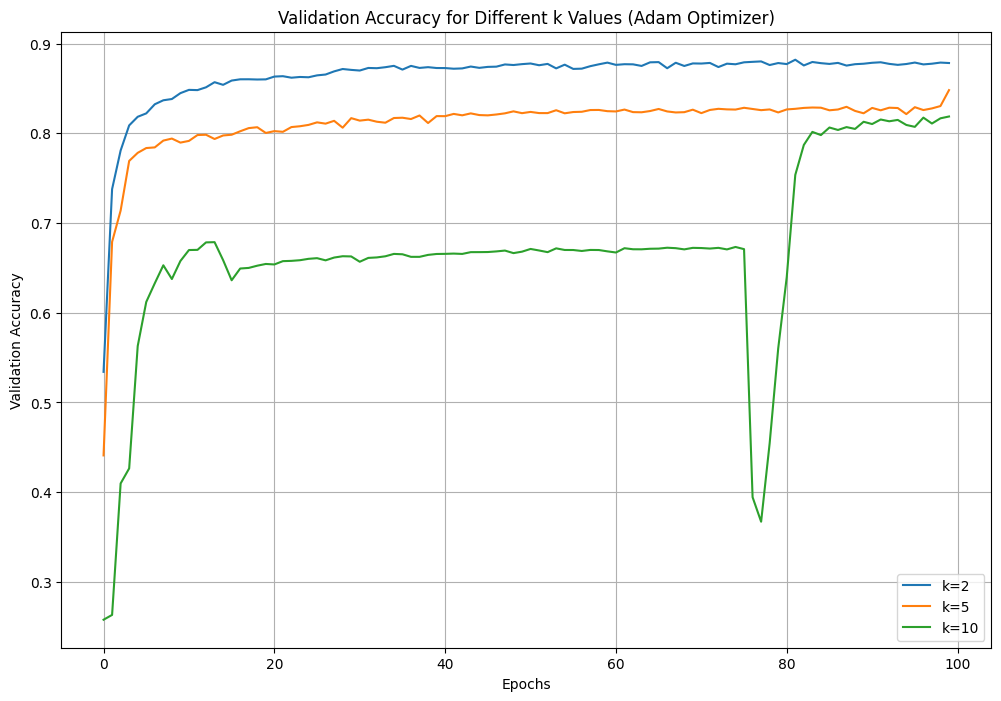

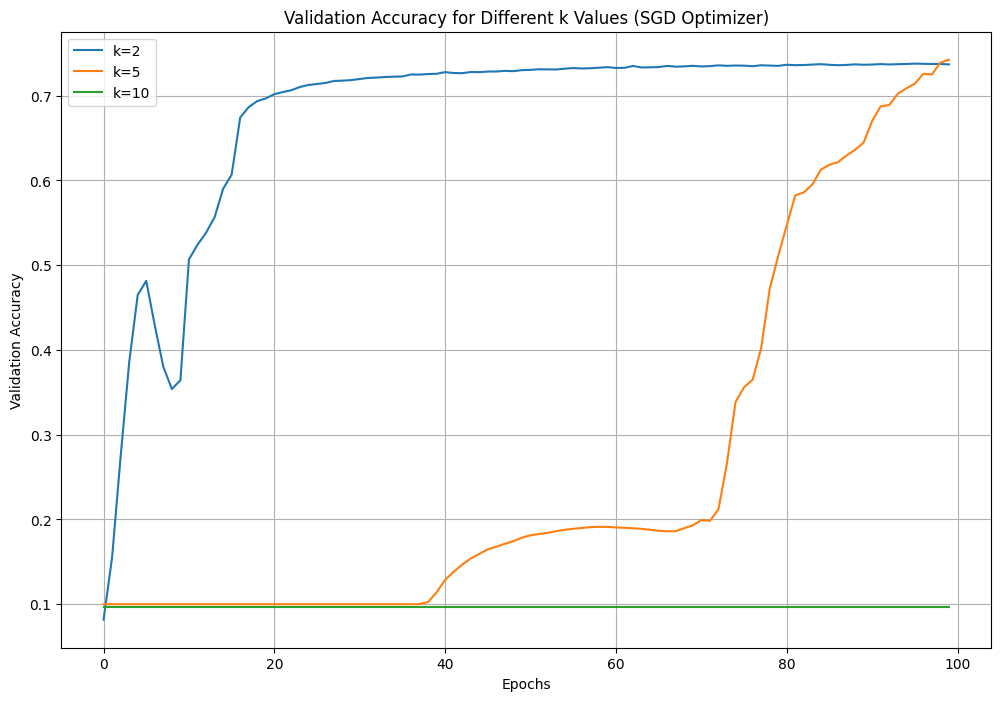

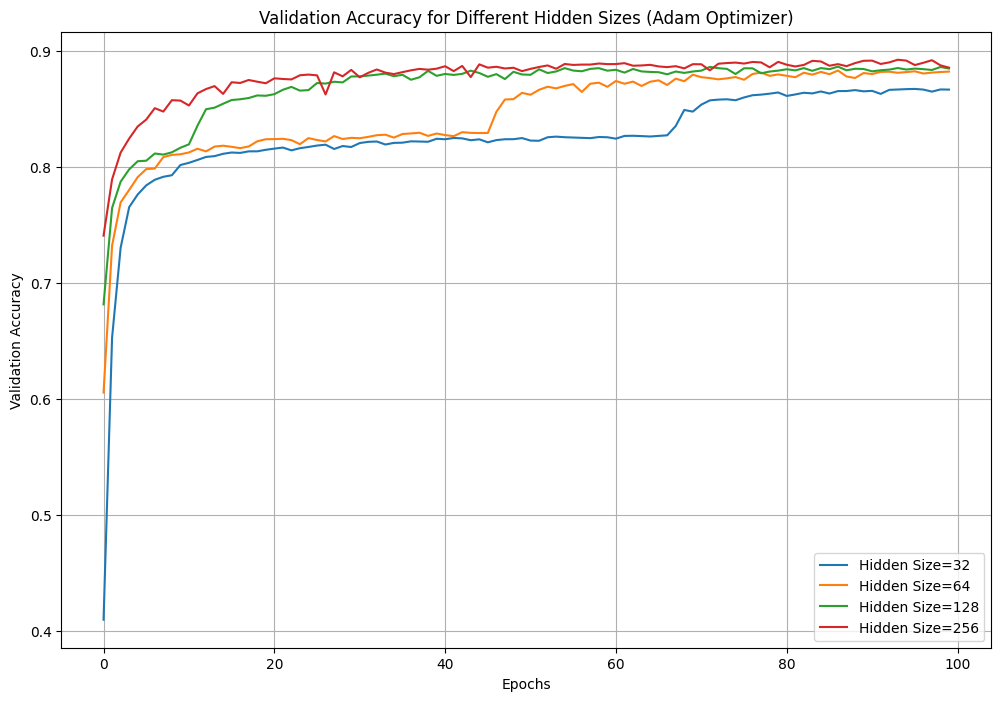

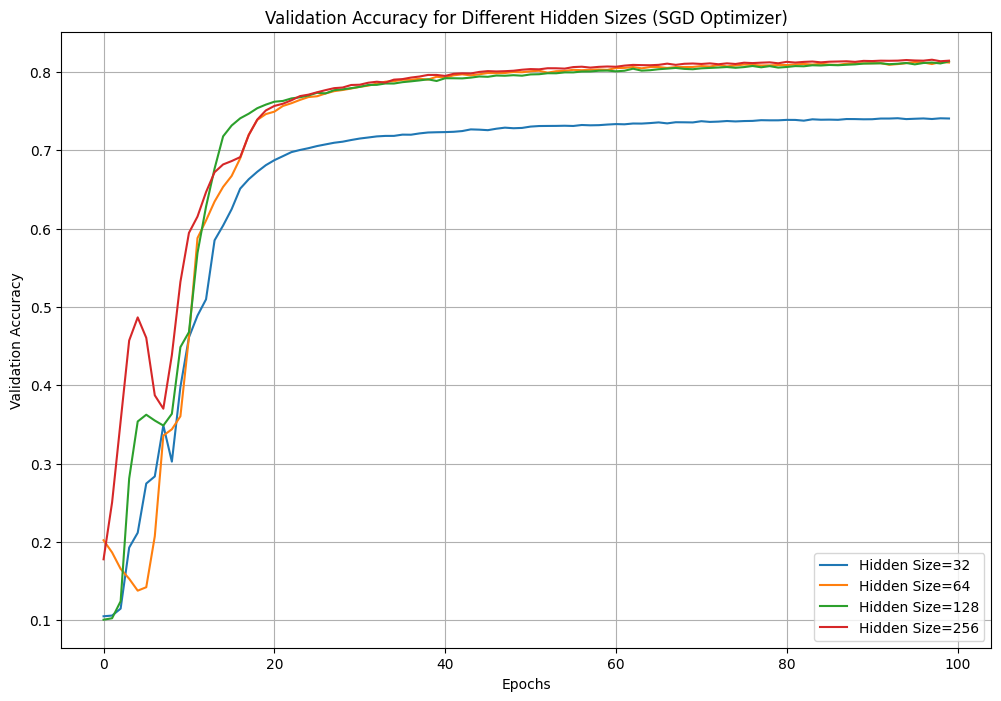

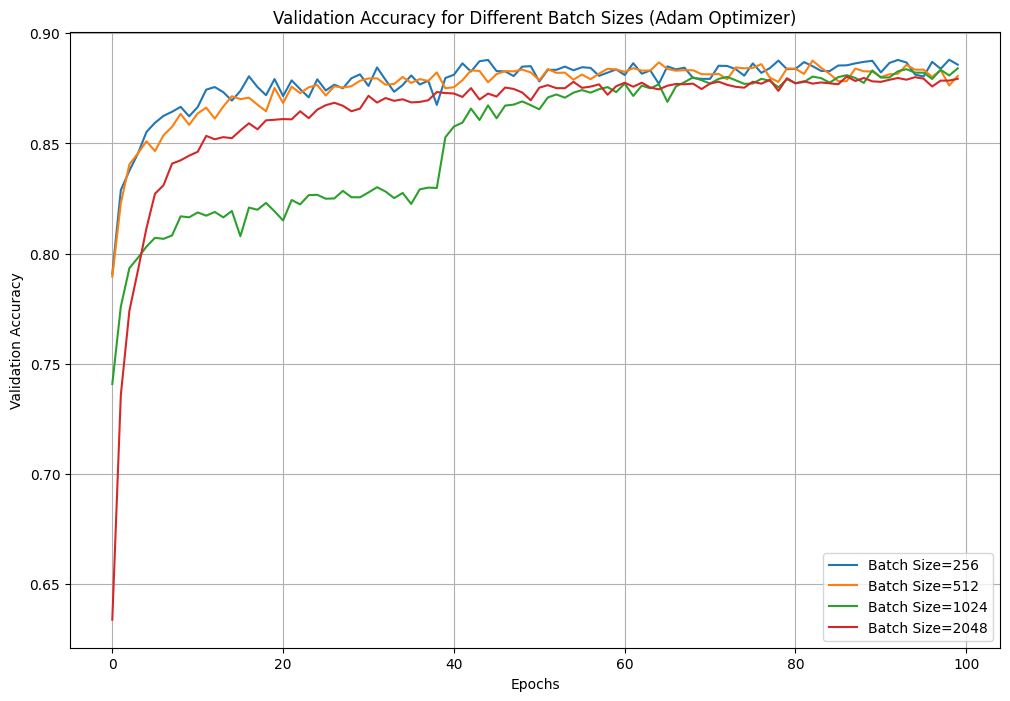

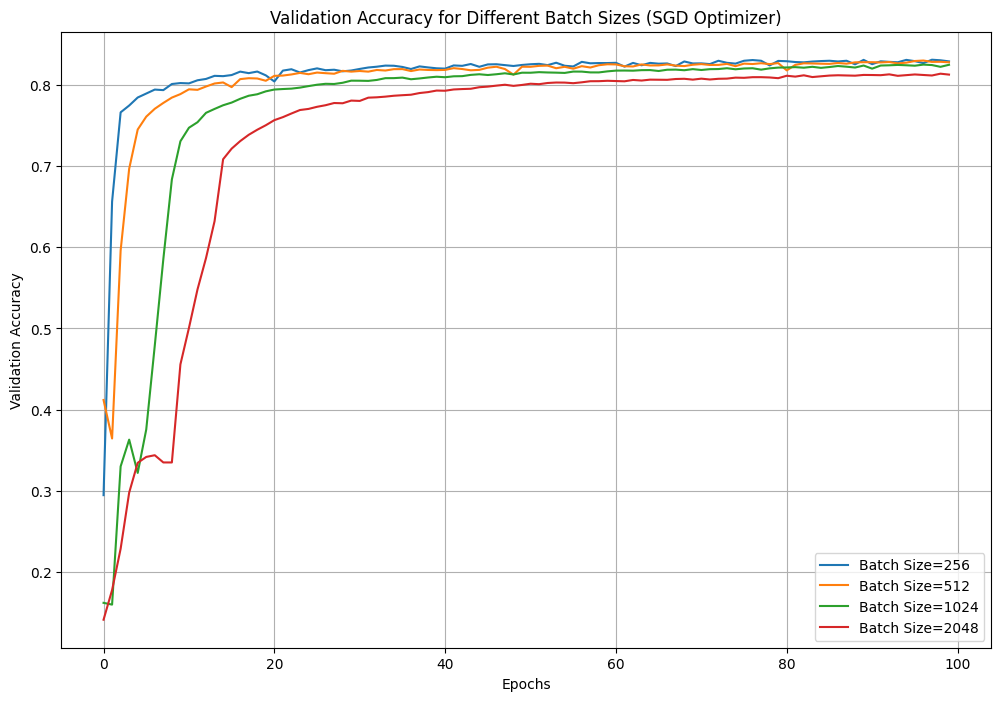

In [28]:
plot_results(results_k_adam, 'Validation Accuracy for Different k Values (Adam Optimizer)')
plot_results(results_k_sgd, 'Validation Accuracy for Different k Values (SGD Optimizer)')
plot_results(results_hidden_size_adam, 'Validation Accuracy for Different Hidden Sizes (Adam Optimizer)')
plot_results(results_hidden_size_sgd, 'Validation Accuracy for Different Hidden Sizes (SGD Optimizer)')
plot_results(results_batch_size_adam, 'Validation Accuracy for Different Batch Sizes (Adam Optimizer)')
plot_results(results_batch_size_sgd, 'Validation Accuracy for Different Batch Sizes (SGD Optimizer)')

**TODO**: Justify which batch size and learning rate combination you will go with.

For the Batch Size it seems to not make a large difference for the convergence. Smaller Batch size seems to converge faster but you make much more mini opitmization steps, which results in this behavior, so we choose 1024, because 2048 performed slightly worse, if we choose the batch size too small the training takes longer because the CPU and GPU communication takes longer. 

For the hidden size 64 performed equally well compared to the others, but we will choose 128 because, the learning seems to not go beyond the 0.75 accurracy mark, and a larger network maybe helps to achieve better accuracies and learns the underlying distribution better. 

For the hidden layers k, we choose 5. It seems sufficient to use 2, but we choose more for the same reason as before.

But we train for more epochs than before

### 2.4

In [32]:
# TODO: Train model w/ best hyperparameters for SGD and compare to default Adam optimizer
best_k = 5
best_hidden_size = 128
best_batch_size = 1024

train_loader = DataLoader(
    train_dataset,
    batch_size=best_batch_size,
    shuffle=True,
    num_workers=12
)
validation_loader = DataLoader(
    validation_dataset,
    batch_size=best_batch_size,
    shuffle=False,
    num_workers=12
)


model_best_sgd = MLP(input_size=input_size, k=best_k, hidden_size=best_hidden_size, output_size=output_size)
optimizer_best_sgd = optim.SGD(model_best_sgd.parameters(), lr=0.01, momentum=0.9)

print("Training model with best hyperparameters using SGD optimizer")
train_losses_best_sgd, val_losses_best_sgd, train_accuracies_best_sgd, val_accuracies_best_sgd = train_model(
    model_best_sgd, criterion, optimizer_best_sgd, train_loader, validation_loader, 200)

model_best_adam = MLP(input_size=input_size, k=best_k, hidden_size=best_hidden_size, output_size=output_size)
optimizer_best_adam = optim.Adam(model_best_adam.parameters())

print("Training model with best hyperparameters using Adam optimizer")
train_losses_best_adam, val_losses_best_adam, train_accuracies_best_adam, val_accuracies_best_adam = train_model(
    model_best_adam, criterion, optimizer_best_adam, train_loader, validation_loader, 200)

Training model with best hyperparameters using SGD optimizer
Training on device: cuda
Epoch [1/200], Train Loss: 2.3026, Train Accuracy: 0.0990, Val Accuracy: 0.1048
Epoch [2/200], Train Loss: 2.3026, Train Accuracy: 0.0989, Val Accuracy: 0.1048
Epoch [3/200], Train Loss: 2.3026, Train Accuracy: 0.0990, Val Accuracy: 0.1048
Epoch [4/200], Train Loss: 2.3025, Train Accuracy: 0.0990, Val Accuracy: 0.1048
Epoch [5/200], Train Loss: 2.3025, Train Accuracy: 0.0990, Val Accuracy: 0.1048
Epoch [6/200], Train Loss: 2.3024, Train Accuracy: 0.0990, Val Accuracy: 0.1048
Epoch [7/200], Train Loss: 2.3024, Train Accuracy: 0.0990, Val Accuracy: 0.1048
Epoch [8/200], Train Loss: 2.3024, Train Accuracy: 0.0989, Val Accuracy: 0.1048
Epoch [9/200], Train Loss: 2.3023, Train Accuracy: 0.0990, Val Accuracy: 0.1048
Epoch [10/200], Train Loss: 2.3022, Train Accuracy: 0.0990, Val Accuracy: 0.1048
Epoch [11/200], Train Loss: 2.3022, Train Accuracy: 0.0990, Val Accuracy: 0.1048
Epoch [12/200], Train Loss: 2.30

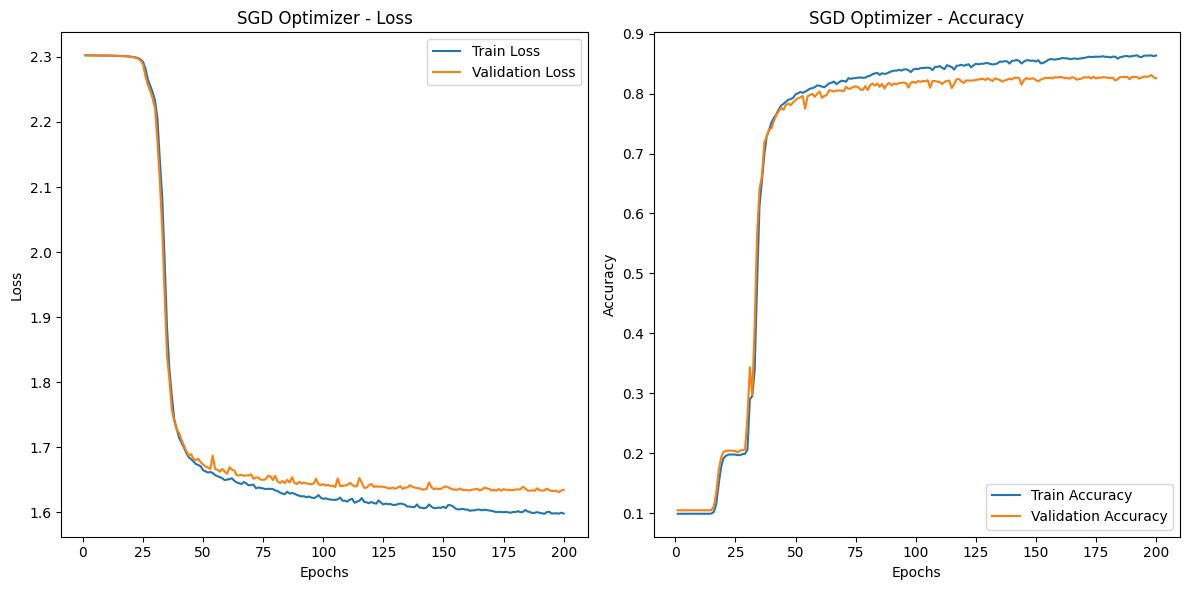

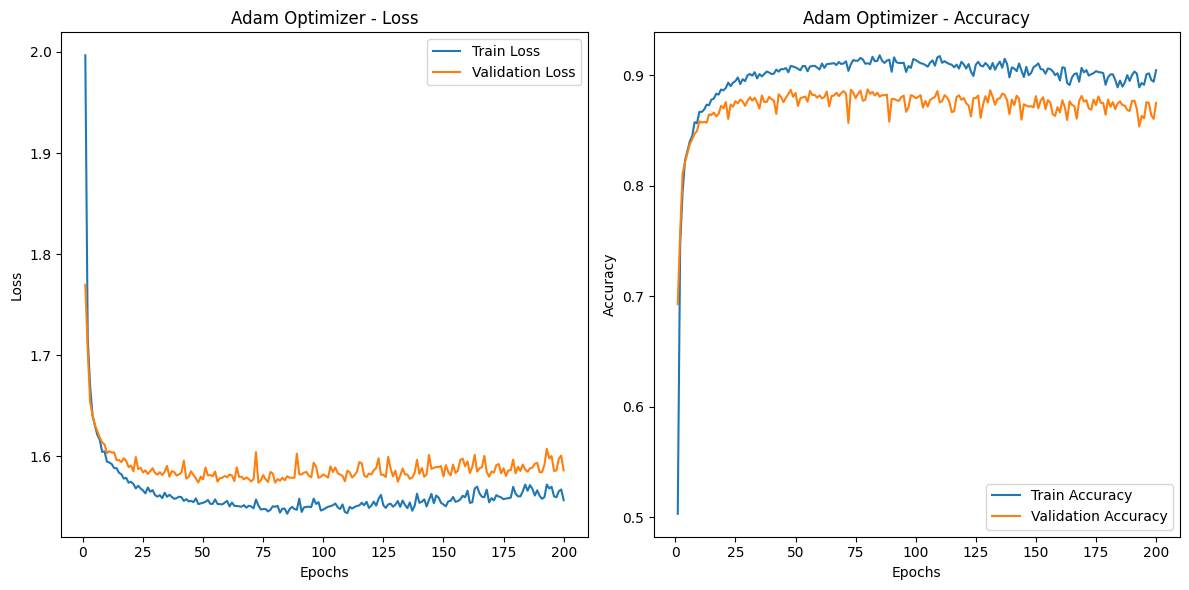

In [33]:
# TODO: Plot "learning curves" of the best SGD model and the Adam model
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(train_losses_best_sgd, val_losses_best_sgd, train_accuracies_best_sgd, val_accuracies_best_sgd, 'SGD Optimizer')
plot_learning_curves(train_losses_best_adam, val_losses_best_adam, train_accuracies_best_adam, val_accuracies_best_adam, 'Adam Optimizer')


**TODO**: Based on plots, compare (mini-batch) SGD and Adam, select overall best Model

Select Adam because overall performance is better

In [34]:
#TODO: Evaluate the best model on the test set, print the test/train/validation accuracy

def evaluate_model(model, test_loader, train_loader, validation_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    test_accuracy = 0.0
    train_accuracy = 0.0
    validation_accuracy = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            test_accuracy += calculate_accuracy(outputs, labels)
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            train_accuracy += calculate_accuracy(outputs, labels)
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            validation_accuracy += calculate_accuracy(outputs, labels)
            
    test_accuracy /= len(test_loader)
    train_accuracy /= len(train_loader)
    validation_accuracy /= len(validation_loader)

    return test_accuracy, train_accuracy, validation_accuracy

test_acc_best, train_acc_best, val_acc_best = evaluate_model(
    model_best_adam, test_loader, train_loader, validation_loader
)

print(f"Adam best model test accuracy: {test_acc_best:.4f}")
print(f"Adam best model train accuracy: {train_acc_best:.4f}")
print(f"Adam best model validation accuracy: {val_acc_best:.4f}")





Adam best model test accuracy: 0.8669
Adam best model train accuracy: 0.9016
Adam best model validation accuracy: 0.8749


**TODO**: Briefly discuss your results.

Adam converged faster than SGD and also had a steeper learning curve. SGD took more epochs to achieve higher accuracies compared to Adam. With more epochs, the results maybe would have been better, but this network is not designed for image classification, odher models would achieve better results.
